## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os
import os.path as osp
import sys

BASE = os.path.dirname(os.path.abspath(os.path.dirname("file"))) # latent_3D
sys.path.append(BASE)  # latent_3D
print(BASE)

from src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from src.autoencoder import Configuration as Conf
from src.point_net_ae import PointNetAutoEncoder

from src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from src.tf_utils import reset_tf_graph
from src.general_utils import plot_3d_point_cloud

/home/sohee/coding/PointCloud/lgan/latent_3d_points
Instructions for updating:
Colocations handled automatically by placer.
/home/sohee/coding/PointCloud/lgan/latent_3d_points/external/structural_losses
Success


In [2]:
# # -*- coding: utf-8 -*-
# import numpy as np
# import os
# import os.path as osp
# import sys
# import matplotlib.pylab as plt

# BASE = os.path.dirname(os.path.abspath(os.path.dirname("file"))) # latent_3D
# sys.path.append(BASE) 

# from src.point_net_ae import PointNetAutoEncoder
# from src.autoencoder import Configuration as Conf
# from src.neural_net import MODEL_SAVER_ID

# from src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
#                                         load_all_point_clouds_under_folder

# from src.general_utils import plot_3d_point_cloud
# from src.tf_utils import reset_tf_graph

# from src.vanilla_gan import Vanilla_GAN
# from src.w_gan_gp import W_GAN_GP
# from src.generators_discriminators import latent_code_discriminator_two_layers,\
# latent_code_generator_two_layers


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [4]:
top_out_dir = 'data/'          # Use to save Neural-Net check-points etc.
top_in_dir = 'data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

top_out_dir = osp.join(BASE, top_out_dir)
top_in_dir = osp.join(BASE, top_in_dir)


class_name = 'chair'
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'

load_pre_trained_ae = False
restore_epoch = 500

experiment_name = osp.join(class_name, 'single_class_ae')
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size

#class_name = input('Give me the class name (e.g. "chair"): ').lower()

Load Point-Clouds

In [5]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

6778 pclouds were loaded. They belong in 1 shape-classes.


Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [6]:
# train_params = default_train_params()
train_params = {'batch_size': 50, 
                'training_epochs': 500,
                'denoising': False,
                'learning_rate': 0.0005,
                'z_rotate': False,
                'saver_step': 10,
                'loss_display_step': 1
               }

In [7]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [8]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

In [9]:
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)
else :
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)

Building Encoder
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
encoder_conv_layer_0 conv params =  256
bnorm params =  128
Tensor("chair/single_class_ae_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320
bnorm params =  256
Tensor("chair/single_class_ae_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512
bnorm params =  256
Tensor("chair/single_class_ae_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024
bnorm params =  512
Tensor("chair/single_class_ae_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896
bnorm params =  256
Tensor("chair/single_class_ae_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("chair/single_class_ae_2/Max:0", sha

Build AE Model.

In [10]:
# reset_tf_graph()
# ae = PointNetAutoEncoder(conf.experiment_name, conf)

Train the AE (save output to train_stats.txt) 

In [11]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

Epoch: 0001 	 training time =  0: 0: 9 	 loss = 0.003469218
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0002 	 training time =  0: 0: 6 	 loss = 0.001653247
Epoch: 0003 	 training time =  0: 0: 6 	 loss = 0.001429857
Epoch: 0004 	 training time =  0: 0: 6 	 loss = 0.001339675
Epoch: 0005 	 training time =  0: 0: 6 	 loss = 0.001227535
Epoch: 0006 	 training time =  0: 0: 6 	 loss = 0.001190864
Epoch: 0007 	 training time =  0: 0: 6 	 loss = 0.001116644
Epoch: 0008 	 training time =  0: 0: 6 	 loss = 0.001082523
Epoch: 0009 	 training time =  0: 0: 6 	 loss = 0.001075486
Epoch: 0010 	 training time =  0: 0: 6 	 loss = 0.001045387
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0011 	 training time =  0: 0: 6 	 loss = 0.000996062
Epoch

Epoch: 0107 	 training time =  0: 0: 6 	 loss = 0.000605315
Epoch: 0108 	 training time =  0: 0: 6 	 loss = 0.000590981
Epoch: 0109 	 training time =  0: 0: 6 	 loss = 0.000606113
Epoch: 0110 	 training time =  0: 0: 6 	 loss = 0.000623769
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0111 	 training time =  0: 0: 6 	 loss = 0.000585871
Epoch: 0112 	 training time =  0: 0: 6 	 loss = 0.000592096
Epoch: 0113 	 training time =  0: 0: 6 	 loss = 0.000601147
Epoch: 0114 	 training time =  0: 0: 6 	 loss = 0.000599194
Epoch: 0115 	 training time =  0: 0: 6 	 loss = 0.000592277
Epoch: 0116 	 training time =  0: 0: 6 	 loss = 0.000577549
Epoch: 0117 	 training time =  0: 0: 6 	 loss = 0.000583243
Epoch: 0118 	 training time =  0: 0: 6 	 loss = 0.000599015
Epoch: 0119 	 training time =  0: 0: 6 	 loss = 0.000594716
Epoch: 0120 	 training time =  0: 0: 6 	 loss = 0.0

Epoch: 0213 	 training time =  0: 0: 6 	 loss = 0.000518821
Epoch: 0214 	 training time =  0: 0: 6 	 loss = 0.000528696
Epoch: 0215 	 training time =  0: 0: 6 	 loss = 0.000525623
Epoch: 0216 	 training time =  0: 0: 6 	 loss = 0.000527689
Epoch: 0217 	 training time =  0: 0: 6 	 loss = 0.000520679
Epoch: 0218 	 training time =  0: 0: 6 	 loss = 0.000519438
Epoch: 0219 	 training time =  0: 0: 6 	 loss = 0.000521420
Epoch: 0220 	 training time =  0: 0: 6 	 loss = 0.000516562
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae/models.ckpt-220 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0221 	 training time =  0: 0: 6 	 loss = 0.000528124
Epoch: 0222 	 training time =  0: 0: 6 	 loss = 0.000521318
Epoch: 0223 	 training time =  0: 0: 6 	 loss = 0.000531749
Epoch: 0224 	 training time =  0: 0: 6 	 loss = 0.000525706
Epoch: 0225 	 training time =  0: 0: 6 	 loss = 0.000524786
Epoch: 0226 	 training time =  0: 0: 6 	 loss = 0.0

Epoch: 0321 	 training time =  0: 0: 6 	 loss = 0.000488833
Epoch: 0322 	 training time =  0: 0: 5 	 loss = 0.000492327
Epoch: 0323 	 training time =  0: 0: 5 	 loss = 0.000492523
Epoch: 0324 	 training time =  0: 0: 5 	 loss = 0.000500581
Epoch: 0325 	 training time =  0: 0: 5 	 loss = 0.000488456
Epoch: 0326 	 training time =  0: 0: 5 	 loss = 0.000493605
Epoch: 0327 	 training time =  0: 0: 5 	 loss = 0.000490230
Epoch: 0328 	 training time =  0: 0: 5 	 loss = 0.000491846
Epoch: 0329 	 training time =  0: 0: 5 	 loss = 0.000490126
Epoch: 0330 	 training time =  0: 0: 5 	 loss = 0.000490553
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae/models.ckpt-330 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0331 	 training time =  0: 0: 5 	 loss = 0.000487053
Epoch: 0332 	 training time =  0: 0: 5 	 loss = 0.000496756
Epoch: 0333 	 training time =  0: 0: 5 	 loss = 0.000496217
Epoch: 0334 	 training time =  0: 0: 5 	 loss = 0.0

Epoch: 0430 	 training time =  0: 0: 5 	 loss = 0.000481737
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae/models.ckpt-430 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0431 	 training time =  0: 0: 5 	 loss = 0.000468791
Epoch: 0432 	 training time =  0: 0: 5 	 loss = 0.000471153
Epoch: 0433 	 training time =  0: 0: 5 	 loss = 0.000474168
Epoch: 0434 	 training time =  0: 0: 5 	 loss = 0.000473145
Epoch: 0435 	 training time =  0: 0: 5 	 loss = 0.000473309
Epoch: 0436 	 training time =  0: 0: 5 	 loss = 0.000476520
Epoch: 0437 	 training time =  0: 0: 5 	 loss = 0.000470133
Epoch: 0438 	 training time =  0: 0: 5 	 loss = 0.000474601
Epoch: 0439 	 training time =  0: 0: 5 	 loss = 0.000476409
Epoch: 0440 	 training time =  0: 0: 5 	 loss = 0.000475919
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae/models.ckpt-440 is not in all_model_checkpoint_paths. Manually adding it.
Ep

[autoreload of external.structural_losses.tf_nndistance failed: Traceback (most recent call last):
  File "/home/sohee/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/sohee/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/home/sohee/anaconda3/envs/python3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/sohee/anaconda3/envs/python3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/sohee/coding/PointCloud/lgan/latent_3d_points/external/structural_losses/tf_nndistance.p

/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae


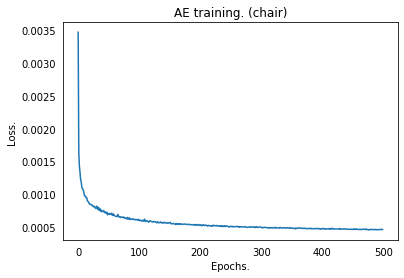

In [12]:
plot_train_curve = True
import matplotlib.pylab as plt

print(conf.train_dir) # ../data/single_class_ae

if plot_train_curve:
    x = range(len(train_stats))
    loss = [t[1] for t in train_stats] # [0] epoch  [1] loss  [2] time

    plt.plot(x, loss)
    plt.title('AE training. (%s)' %(class_name))
    
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.tick_params(axis='y', which='both', left=False, right=False)
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')

In [13]:
how_long_time = True


if how_long_time:
    time = [t[2] for t in train_stats] 
total = sum(time)  
m, s = divmod(total, 60)
h, m = divmod(m, 60)

print('Total runtime : %2d:%2d:%2d / %d epoch' %(h, m, s, len(time)))

Total runtime :  0:51:33 / 500 epoch


Get a batch of reconstuctions and their latent-codes.

In [61]:
num = 819
feed_pc, feed_model_names, _ = all_pc_data.next_batch(num)
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

Use any plotting mechanism such as matplotlib to visualize the results.

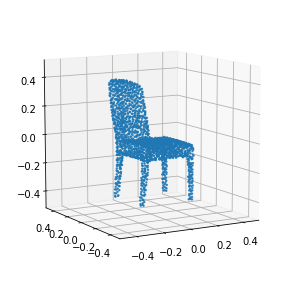

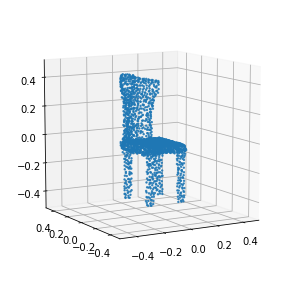

In [62]:
i = 2
plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);

i = 4
plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);

Save

In [17]:
# f = open(osp.join(conf.train_dir, 'ae_reconstruction.txt'), 'a')
# f.write(reconstructions)
# f.close()

In [74]:
import numpy as np
import pandas as pd
import os           
import tensorflow as tf

def createDir(dirname, path=os.getcwd()):
    dirpath = osp.join(path, dirname)
    try:
        os.mkdir(dirpath)
    except OSError as error:
        print ("exist")
        
# os.makedirs(osp.join(conf.train_dir, 'ae_npy'))
# os.makedirs(osp.join(conf.train_dir, 'ae_txt'))

createDir('ae_npy', conf.train_dir)
createDir('ae_txt', conf.train_dir)
      
      
for i in range(0,num):
    xx = reconstructions[i][:, 0]
    x = xx.tolist()
    #     x = tf.convert_to_tensor(xx, dtype = tf.float32)
    
    yy = reconstructions[i][:, 1]
    y = yy.tolist()
    zz = reconstructions[i][:, 2]
    z = zz.tolist()
    
    np.save(osp.join(conf.train_dir, 'ae_npy', 'ae_recon_'+ str(i).zfill(5) +'.npy'), reconstructions[i])
      
    p = open(osp.join(conf.train_dir, 'ae_txt', 'ae_recon_'+ str(i).zfill(5) +'.txt'), 'w+')
    for k in range(0,2048):          
        p.write('%8f\t%8f\t%8f\n' %(x[k], y[k], z[k]))
    p.close()

exist
exist


In [ ]:
reset_tf_graph()